In [2]:
import tensorflow as tf

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11651589437962531773
xla_global_id: -1
]


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
import os

file_path = 'DenseNet169v3GaussianTrainable.keras'  # Modifier avec le chemin approprié
if not os.path.exists(file_path):
    print(f"Le fichier {file_path} n'existe pas.")
else:
    print(f"Le fichier {file_path} existe.")

Le fichier DenseNet169v3GaussianTrainable.keras existe.


In [6]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, GaussianNoise,RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Conv2D


base_model = DenseNet169(include_top = False)

fine_tune_at = 550
base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

model = Sequential([
    RandomFlip("horizontal", input_shape=(224, 224, 3)),
    RandomRotation(0.3),
    GaussianNoise(0.1),
    BatchNormalization(),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(400, activation="relu"),
    Dense(500, activation='softmax')
])

model.summary()

d:\miniconda\envs\python_a\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │       666,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       200,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,509,392 (51.53 MB)

 Trainable params: 2,303,114 (8.79 MB)

 Non-trainable params: 11,206,278 (42.75 MB)

In [7]:
model.load_weights('save.weights.h5')

In [12]:
dataset_path = './download/images/'



train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(224, 224),
    batch_size=120)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(224, 224),
    batch_size=120)

class_names = train_dataset.class_names

train_dataset = train_dataset.map(lambda x, y: (x/255, y))
validation_dataset = validation_dataset.map(lambda x, y: (x/255, y))

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 39615 files belonging to 500 classes.
Using 31692 files for training.
Found 39615 files belonging to 500 classes.
Using 7923 files for validation.


In [14]:
predictions = model.predict(validation_dataset)

67/67 ━━━━━━━━━━━━━━━━━━━━ 614s 9s/step


In [28]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
model.evaluate(validation_dataset)

67/67 ━━━━━━━━━━━━━━━━━━━━ 546s 8s/step - accuracy: 0.4150 - loss: 2.6379


[2.5783324241638184, 0.42635366320610046]

In [70]:
top3label = tf.math.top_k(predictions, k=3).indices.numpy()
t3labels = [[class_names[index] for index in prediction] for prediction in top3label]

In [71]:
import numpy as np

predicted_labels = []
true_labels = []

for images, labels in validation_dataset:
    
    true_label_indices = np.argmax(labels.numpy(), axis=1)
    true_labels.extend(true_label_indices)


true_label_names = [class_names[idx] for idx in true_labels]

In [72]:
print(len(top3label))

7923


In [73]:
count_matches = sum(1 for true, top3 in zip(true_label_names, t3labels) if true in top3)

print(f"Nombre de correspondances où le vrai label est dans le top 3: {count_matches}, soit {count_matches/len(top3label)*100}%")

Nombre de correspondances où le vrai label est dans le top 3: 5054, soit 63.78896882494005%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
True label: Bairds_Sandpiper


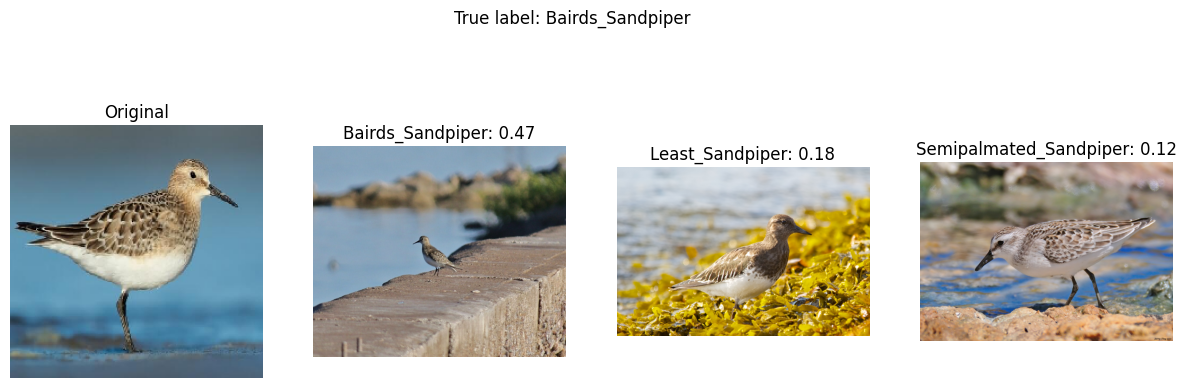

(['Bairds_Sandpiper', 'Least_Sandpiper', 'Semipalmated_Sandpiper'],
 array([0.46913493, 0.18411323, 0.11665298], dtype=float32))

In [85]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image

def predict_top3_labels(model, img_path, true_label=None, dataset_path="./download/images"):
    """
    Prédire les 3 meilleures classes pour une image donnée, comparer avec le vrai label, et afficher une image aléatoire pour chaque label.

    Args:
    - model: Le modèle entraîné.
    - img_path: Le chemin vers l'image.
    - true_label: Le vrai label de l'image (facultatif).
    - dataset_path: Le chemin vers le dossier contenant les images organisées par classe.

    Returns:
    - Un tuple contenant les 3 meilleurs labels et leurs probabilités.
    """

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    predictions = model.predict(img_array)
    top3_indices = tf.math.top_k(predictions, k=3).indices.numpy().flatten()
    top3_labels = [class_names[index] for index in top3_indices]
    top3_probabilities = predictions[0, top3_indices]

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title("Original")

    for i, (label, prob) in enumerate(zip(top3_labels, top3_probabilities)):
        class_folder = os.path.join(dataset_path, label)
        random_image = random.choice(os.listdir(class_folder))
        random_img_path = os.path.join(class_folder, random_image)
        random_img = Image.open(random_img_path)


        axes[i+1].imshow(random_img)
        axes[i+1].axis('off')
        axes[i+1].set_title(f"{label}: {prob:.2f}")


    if true_label:
        print(f"True label: {true_label}")
        plt.suptitle(f"True label: {true_label}")

    plt.show()

    return top3_labels, top3_probabilities

img_path = "./images_test/sandpiper.jpg" 
true_label = "Bairds_Sandpiper"
predict_top3_labels(model, img_path, true_label)